<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


#### Tutorial 3.1:  Parameter estimation for compact object mergers -- Using and interpreting posterior samples

This is a simple demonstration to loading and viewing data released in associaton with the publication titled __GWTC-1: A Gravitational-Wave Transient Catalog of Compact Binary Mergers Observed by LIGO and Virgo during the First and Second Observing Runs__ avaliable through [DCC](https://dcc.ligo.org/LIGO-P1800307/public) and [arXiv](https://arxiv.org/abs/1811.12907). This should lead to discussion and interpretation.

The data used in these tutorials will be downloaded from the public DCC page [LIGO-P1800370](https://dcc.ligo.org/LIGO-P1800370/public).

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2022/blob/main/Tutorials/Day_3/Tuto_3.1_Parameter_estimation_for_compact_object_mergers.ipynb)

## Installation (execute only if running on a cloud platform!)¶

In [1]:
# -- Use the following line for google colab
#! pip install -q 'corner==2.0.1' 'bilby==1.0.4' 'astropy==4.0.3'

**Important**: With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner

## Get the data

Selecting the event, let's pick GW150914.

In [3]:
label = 'GW150914'

# if you do not have wget installed, simply download manually 
# https://dcc.ligo.org/LIGO-P1800370/public/GW150914_GWTC-1.hdf5 
# from your browser
! wget https://dcc.ligo.org/LIGO-P1800370/public/{label}_GWTC-1.hdf5

--2022-05-05 12:53:03--  https://dcc.ligo.org/LIGO-P1800370/public/GW150914_GWTC-1.hdf5
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5 [following]
--2022-05-05 12:53:03--  https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5
Reusing existing connection to dcc.ligo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 7026464 (6.7M)
Saving to: ‘GW150914_GWTC-1.hdf5’

GW150914_GWTC-1.hdf 100%[===================>]   6.70M  --.-KB/s    in 0.09s   

2022-05-05 12:53:04 (73.7 MB/s) - ‘GW150914_GWTC-1.hdf5’ saved [7026464/7026464]



In [4]:
posterior_file = './'+label+'_GWTC-1.hdf5'
posterior = h5py.File(posterior_file, 'r')

### Looking into the file structure

In [5]:
print('This file contains four datasets: ',posterior.keys())

This file contains four datasets:  <KeysViewHDF5 ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']>


This data file contains several datasets, two using separate models for the gravitational waveform (`IMRPhenomPv2` and `SEOBNRv3` respectively, see the [paper](https://arxiv.org/abs/1811.12907) for more details). 

It also contiains a joint dataset, combining equal numbers of samples from each individual model, these datasets are what is shown in the [paper](https://arxiv.org/abs/1811.12907). 

Finally, there is a dataset containing samples drawn from the prior used for the analyses.

In [6]:
print(posterior['Overall_posterior'].dtype.names)

('costheta_jn', 'luminosity_distance_Mpc', 'right_ascension', 'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun', 'spin1', 'spin2', 'costilt1', 'costilt2')


Here are some brief descriptions of these parameters and their uses:

 * `luminosity_distance_Mpc`: luminosity distance [Mpc]

 * `m1_detector_frame_Msun`: primary (larger) black hole mass (detector frame) [solar mass]

 * `m2_detector_frame_Msun`: secondary (smaller) black hole mass (detector frame) [solar mass]

 * `right_ascension`, `declination`: right ascension and declination of the source [rad].

 * `costheta_jn`: cosine of the angle between line of sight and total angular momentum vector of system.

 * `spin1`, `costilt1`: primary (larger) black hole spin magnitude (dimensionless) and cosine of the zenith angle between the spin and the orbital angular momentum vector of system.

 * `spin2`, `costilt2`: secondary (smaller) black hole spin magnitude (dimensionless) and cosine of the zenith angle between the spin and the orbital angular momentum vector of system.

A convenient (and pretty) way to load up this array of samples is to use [pandas](https://pandas.pydata.org/):

In [7]:
samples=pd.DataFrame.from_records(np.array(posterior['Overall_posterior']))

In [8]:
samples

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,spin1,spin2,costilt1,costilt2
0,-0.976633,517.176717,1.456176,-1.257815,39.037380,37.044563,0.417147,0.867740,-0.280624,0.403853
1,-0.700404,401.626864,2.658802,-0.874661,34.620096,34.184416,0.125709,0.260679,-0.757349,-0.312285
2,-0.840752,369.579071,1.106548,-1.136396,37.894343,33.970520,0.581047,0.926893,0.649781,-0.510843
3,-0.583657,386.935268,2.077180,-1.246351,36.412973,35.684463,0.235808,0.094391,0.116578,-0.720505
4,-0.928271,345.104345,0.993604,-1.069243,39.477251,31.645008,0.511521,0.868009,-0.438237,0.269333
...,...,...,...,...,...,...,...,...,...,...
8345,-0.691637,306.985025,1.485646,-1.269228,37.561962,33.355792,0.484003,0.627191,0.194507,-0.408345
8346,-0.834615,462.649414,2.065362,-1.265618,37.824298,36.674075,0.589654,0.650758,-0.737792,0.875384
8347,-0.911463,448.930876,1.536913,-1.257956,38.063291,35.757913,0.708407,0.714805,0.852085,-0.797475
8348,-0.856914,561.020036,2.367289,-1.211824,44.884396,31.592433,0.389284,0.521304,-0.251461,0.830526


Those are all the samples stored in the `Overall` dataset. 

### Plotting

We can plot all of them with, for instance, the [corner](https://corner.readthedocs.io/en/latest/) package:

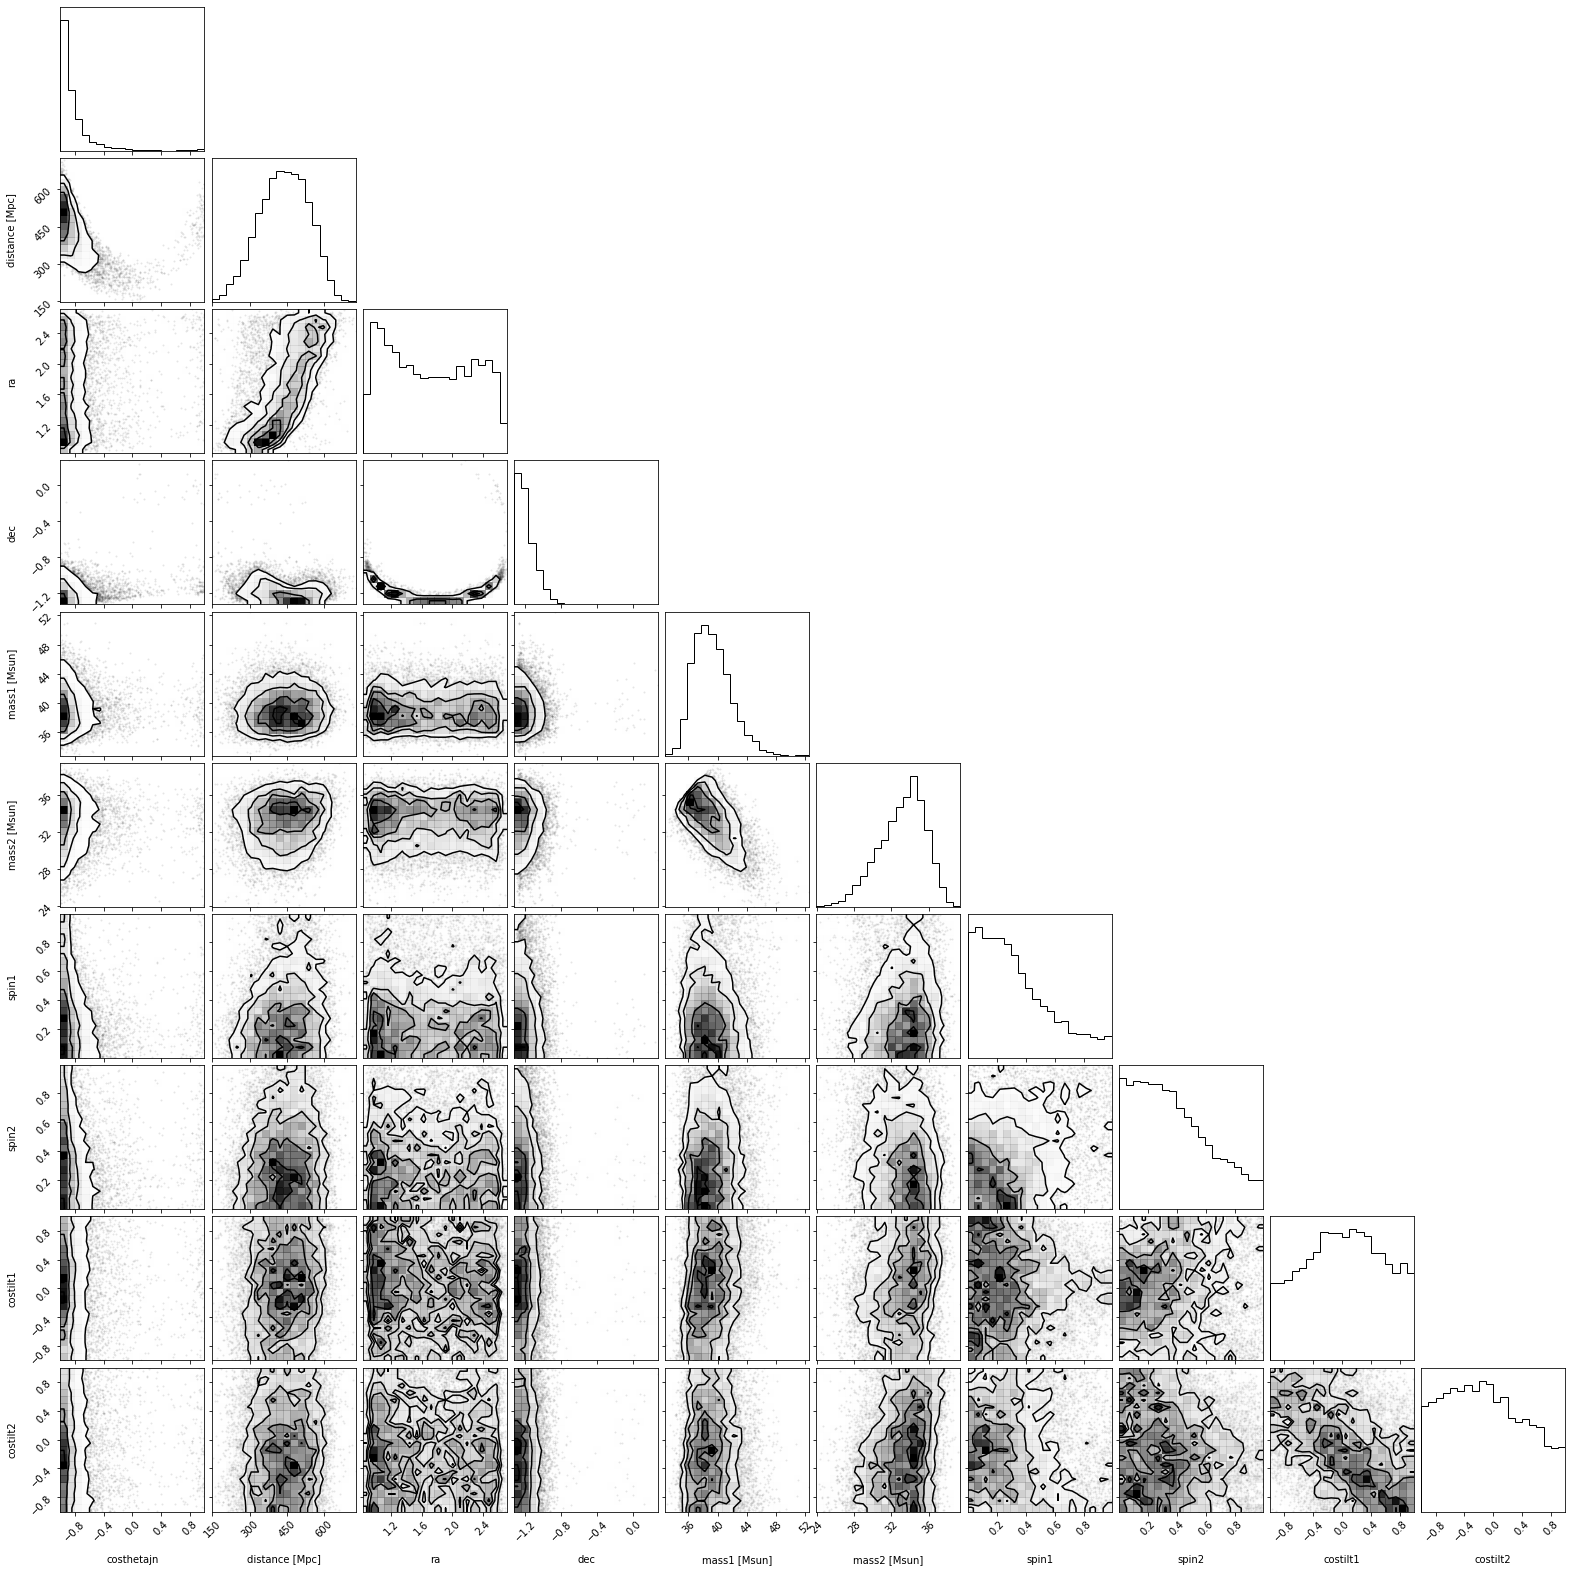

In [9]:
corner.corner(samples,labels=['costhetajn',
                                'distance [Mpc]',
                                'ra',
                                'dec',
                                'mass1 [Msun]',
                                'mass2 [Msun]',
                                'spin1',
                                'spin2',
                                'costilt1',
                                'costilt2']);

Each one and two dimentional histogram are *marginalised* probability density functions. We can manualy select one parameter, say `luminosity distance`, and plot the four different marginalised distributions:

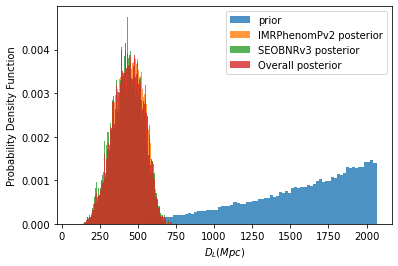

In [10]:
plt.hist(posterior['prior']['luminosity_distance_Mpc'], bins = 100, label='prior', alpha=0.8, density=True)
plt.hist(posterior['IMRPhenomPv2_posterior']['luminosity_distance_Mpc'], bins = 100, label='IMRPhenomPv2 posterior', alpha=0.8, density=True)
plt.hist(posterior['SEOBNRv3_posterior']['luminosity_distance_Mpc'], bins = 100, label='SEOBNRv3 posterior', alpha=0.8, density=True)
plt.hist(posterior['Overall_posterior']['luminosity_distance_Mpc'], bins = 100, label='Overall posterior', alpha=0.8, density=True)
plt.xlabel(r'$D_L (Mpc)$')
plt.ylabel('Probability Density Function')
plt.legend()
plt.show()

### Computing new quantities

The masses given are the ones measured at the detector, i.e. in the *detector frame*. To get the actual (*source frame*) masses of the source black holes, we need to correct for the cosmological redshift of the gravitational wave. This forces us to assume a cosmology:

In [11]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

We now compute the redshift value for all the samples (using only their distance value). See [astropy.cosmology](http://docs.astropy.org/en/stable/api/astropy.cosmology.z_at_value.html) for implementation details, in particular how to make the following more efficient:

In [12]:
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc) for dist in samples['luminosity_distance_Mpc']])

In [13]:
samples['m1_source_frame_Msun']=samples['m1_detector_frame_Msun']/(1.0+z)
samples['m2_source_frame_Msun']=samples['m2_detector_frame_Msun']/(1.0+z)
samples['redshift']=z

And we can plot the marginalised probability density functions:

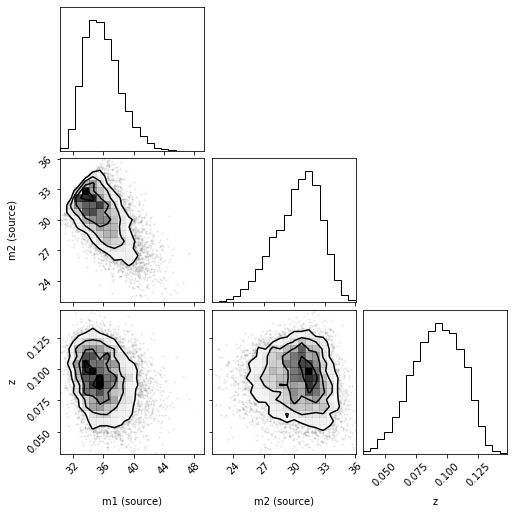

In [14]:
corner.corner(samples[['m1_source_frame_Msun','m2_source_frame_Msun','redshift']],labels=['m1 (source)',
                                                                                          'm2 (source)',
                                                                                          'z']);

## Calculating credible intervals
Let's see how we can use Bilby to calcuate summary statistics for the posterior like the median and 90% credible level.

In [15]:
import bilby
# calculate the detector frame chirp mass
mchirp = ((samples['m1_detector_frame_Msun'] * samples['m2_detector_frame_Msun'])**(3./5))/\
         (samples['m1_detector_frame_Msun'] + samples['m2_detector_frame_Msun'])**(1./5)
# initialize a SampleSummary object to describe the chirp mass posterior samples
chirp_mass_samples_summary = bilby.core.utils.SamplesSummary(samples=mchirp, average='median')
print('The median chirp mass = {} Msun'.format(chirp_mass_samples_summary.median))
print('The 90% confidence interval for the chirp mass is {} - {} Msun'.format(chirp_mass_samples_summary.lower_absolute_credible_interval,
                                                                        chirp_mass_samples_summary.upper_absolute_credible_interval))

The median chirp mass = 31.23055308109465 Msun
The 90% confidence interval for the chirp mass is 29.65587710846462 - 32.97324559242388 Msun


## Challenge question
Calculate the posterior for the effective spin, which is the mass-weighted component of the binary spin aligned to the orbital angular momentum. It is given by Eqn. 3 of https://journals.aps.org/prx/pdf/10.1103/PhysRevX.9.011001. The z-component of each component spin is defined as $\chi_{1z} = \chi_{1}\cos{\theta_{1}}$. Then initialize a `SamplesSummary` object for the chi_eff posterior and calculate the mean and the lower and upper absolute credible interval. 